# Talos Example

In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
import os, time
from tf_robot_learning import kinematic as tk

from IPython.core import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Part 1: Define and Train GAN

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

### Define robot

In [3]:
urdf = tk.urdf_from_file(rl.datapath + '/urdf/talos_reduced.urdf');
display.clear_output()

#list of end-effector
tips = OrderedDict({
    'r_gripper'	: 'gripper_right_base_link',
    'l_gripper'	: 'gripper_left_base_link',
    'r_foot' 	: 'right_sole_link',
    'l_foot' 	: 'left_sole_link',
})

#define the robot as a kinematic chain, loaded from urdf
chain_names = ['r_gripper', 'r_foot', 'l_foot'] 
chain = tk.ChainDict({
    name: tk.kdl_chain_from_urdf_model(urdf, 'base_link', tip=tip)
    for name, tip in tips.items()
})

#define the default position and orientation of the end-effector
ee = OrderedDict({
        'l_gripper': [0.  , 0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'r_gripper': [0.  , -0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'l_foot': [-0.02,  0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
        'r_foot': [-0.02,  -0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
})

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


### Load data 

In [4]:
def param_to_joint_pos(x):
    """
    convert the config parameter x to full robot configurations: joint angles, base position and orientation
    """
    return x[..., :chain.nb_joint],\
        tf.concat([x[..., chain.nb_joint:chain.nb_joint+3]], -1),\
        tk.rotation.rpy(tf.zeros_like(x[..., -3:]))

In [5]:
def q_augmented(q):
    """ Define augmented data transformations: (joint_angles, right foot pose, and left foot pose)"""
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat([
            q,
            chain.xs(_q, floating_base=(_p, _m), name='r_foot')[:, -1],
            chain.xs(_q, floating_base=(_p, _m), name='l_foot')[:, -1]
        ], -1)

In [6]:
def q_target(q):
    """ Extract the target"""
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat( # orientation of each foot
            [chain.xs(_q, floating_base=(_p, _m), name=name)[:, -1, :3] for name in chain_names]
            , -1)

In [7]:
def q_foot_ori(q):
    """ Extract the foot orientation """
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat( # position of each end-effector
            [chain.xs(_q, floating_base=(_p, _m), name=name)[:, -1, 3:] for name in chain_names[1:]]
            , -1)

In [8]:
# get mini batch
def get_batch(_batch_size=30, cut=None, augmented=True):
    if cut is not None: idx = np.random.randint(0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    if augmented: return data_augmented[idx]
    else: return data[idx]
    
def get_target_batch(_batch_size=30, cut=None):
    if cut is not None: idx = np.random.randint( 0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    return data_target[idx]


In [9]:
q_eval = tf1.placeholder(tf.float32, (None, chain.nb_joint + 3))

q_augmented_eval = q_augmented(q_eval)
q_target_eval = q_target(q_eval)
q_foot_ori_eval = q_foot_ori(q_eval)

In [10]:
#load the dataset
data = np.load('data/data_two_feet_manual.npy')
# compute data through these transformations
data_augmented = q_augmented_eval.eval({q_eval: data})
data_target = q_target_eval.eval({q_eval: data})

## Generator 

In [11]:
# Network Parameters
joint_dim = chain.nb_joint + 3 # the configuration consists of nb_joint= 28 joint angles and 3 base position
latent_dim = 30 # dimension of noise
N_net = 5
target_dim = 9  # size of the target
augmented_dim = 2 * 12 + joint_dim # size of augmented data (joint angles + poses of both foot)

n_input = latent_dim + target_dim #dimension of the input to the generator
batch_size = tf1.placeholder(tf.int32, ())

#### Define the generator

In [12]:
gen_nn = rl.nn.MLP(
    n_input=n_input, n_output=joint_dim, n_hidden=[200, 200],
    act_fct=tf.nn.relu, batch_size_svi=N_net
)

#### Define the generator input

In [13]:
# noise to feed generator
eps_var = tf1.placeholder(tf.float32, ())
eps = tf.random.normal([tf.cast(batch_size/N_net, tf.int32), latent_dim], 
    dtype=tf.float32, mean=0., stddev=eps_var, name='epsilon')

#the input to generator = noise + target
batch_target = tf1.placeholder(tf.float32, (None, target_dim))
eps_conc = tf.concat([eps, batch_target], axis=-1)

#### Define output transformations

In [14]:
samples_q = tf.reshape(gen_nn.pred(eps_conc) + tf.constant(chain.mean_pose + [0,0,1.08])[None], (-1, joint_dim))

samples_qq, samples_p, samples_m = param_to_joint_pos(samples_q)
samples_links, _, samples_com = chain.xs(samples_qq, floating_base=(samples_p, samples_m), get_links=True)

samples_augmented = q_augmented(samples_q)
samples_target = q_target(samples_q)
samples_foot_ori = q_foot_ori(samples_q)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Discriminator

#### Define the discriminator

In [15]:
discr_nn = rl.nn.MLP(
    n_input=augmented_dim, n_output=1, n_hidden=[40, 40],
    act_fct=tf.nn.relu
)

#batch data
batch_x = tf1.placeholder(tf.float32, (None, augmented_dim))

## Define loss functions

#### Main loss functions (discriminator vs generator)

In [16]:
d_fake = discr_nn.pred(samples_augmented)[:, 0]
d_true = discr_nn.pred(batch_x)[:, 0]

#discriminator loss function
loss_d = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_true), logits=d_true) + \
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake)
loss_d = tf.reduce_sum(loss_d)

#generator (basic) loss function
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(d_fake), logits=d_fake)
loss = tf.reduce_sum(loss)

#### Target loss 

In [17]:
p_target_std = tf1.placeholder(tf.float32, ()) 

p_target = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_target,(-1, target_dim)), p_target_std**2 * tf.eye(target_dim)
)

loss_target = tf.reduce_sum(-p_target.log_prob(samples_target))
lmbda_target = tf1.placeholder(tf.float32, ())

Instructions for updating:
Do not call `graph_parents`.


#### Foot orientation loss 

In [18]:
foot_ori_dim = 18
batch_foot_ori = tf1.placeholder(tf.float32, (None, foot_ori_dim))

# define a Gaussian distribution that should be tracked by the system
p_foot_ori_std = tf1.placeholder(tf.float32, ()) 

p_foot_ori = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_foot_ori,(-1, foot_ori_dim)), p_foot_ori_std**2 * tf.eye(foot_ori_dim)
)

loss_foot_ori = tf.reduce_sum(-p_foot_ori.log_prob(samples_foot_ori))
lmbda_foot_ori = tf1.placeholder(tf.float32, ())

#### Constraints cost: COM and joint limit

In [19]:
#joint limit
base_pos_limits = np.array([[-0.1, -0.1, 0.6],[0.1, 0.1, 1.4] ]).T
config_limits = np.concatenate([chain.joint_limits, base_pos_limits], axis=0)
joint_limits = tf.constant(config_limits, dtype=tf.float32)
joint_limits_std = 0.05
joint_limits_temp = 1.

joint_limits_exp = ds.SoftUniformNormalCdf(
    low=joint_limits[:, 0],
    high=joint_limits[:, 1],
    std=joint_limits_std,
    temp=joint_limits_temp,
    reduce_axis=-1
)

joint_limit_constraints = tf.reduce_mean(-joint_limits_exp.log_prob(samples_q[:,:chain.nb_joint+3]))


#COM
com_limits = 0.1
com_limits_std = 0.01

com_limits_exp = ds.SoftUniformNormalCdf(
    low=-com_limits,
    high=com_limits,
    std=com_limits_std,
    temp=1.,
    reduce_axis=-1
)

com_xy = samples_com[:, :2]
center_feet = tf.reduce_mean([
        samples_links['r_foot'][:, -1, :2], 
        samples_links['l_foot'][:, -1, :2]
        ], axis=0)

cost_constraints = tf.reduce_mean(-com_limits_exp.log_prob(com_xy - center_feet))
lmbda_constraints = tf1.placeholder(tf.float32, ())

### Overall loss

In [20]:
loss_gen = loss +  lmbda_target * loss_target + lmbda_foot_ori*loss_foot_ori + lmbda_constraints * (cost_constraints+joint_limit_constraints) 

### Optimizer 

In [21]:
rate = tf1.placeholder(tf.float32, ())
opt = tf1.train.AdamOptimizer

optimizer = opt(learning_rate=rate)
optimizer_d = opt(learning_rate=rate)

train = optimizer.minimize(loss_gen, var_list=gen_nn.vec_weights)
train_d = optimizer_d.minimize(loss_d, var_list=discr_nn.vec_weights)

# Initialize the variables (i.e. assign their default value)
init = tf1.global_variables_initializer()

## Training model 

In [22]:
sess.run(init)

In [23]:
def get_target_new_batch(_batch_size):
    return np.random.multivariate_normal(_targets_m, np.diag(_targets_v ** 2), (_batch_size, ))

In [24]:
_batch_size = 100
_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_batch_foot_ori = np.tile(np.eye(3).flatten(), (int(_batch_size/N_net),2)).reshape(int(_batch_size/N_net),-1)

_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_targets_v = np.array([0.5] * 3 + [0.01] * 2 + [0.] +  [0.01] * 2 + [0.]  )  # variance

#### To save model

#### To load model

In [25]:
saver = tf1.train.Saver()
saver.restore(sess, "data/talos_foot_fixed_with_data_ensemble2.ckpt")

INFO:tensorflow:Restoring parameters from data/talos_foot_fixed_with_data_ensemble2.ckpt


### Visualize the generated samples

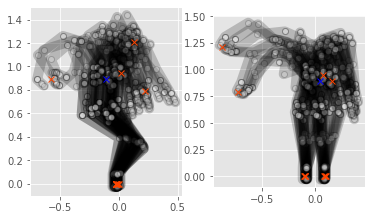

In [26]:
_batch_size = 20
feed_dict={batch_size: _batch_size, eps_var:1.}
feed_dict[batch_target] = get_target_new_batch(_batch_size=int(_batch_size/N_net))

_links, _com , _b_targets = sess.run(
[samples_links, samples_com, batch_target], feed_dict
)

fig, ax = plt.subplots(ncols=2)

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    ax[i].plot(_com[0, dim[0]], _com[0, dim[1]], 'bx')
    
    for j, name in enumerate(chain_names):
        ax[i].plot(_b_targets[:, j*3 + dim[0]], _b_targets[:, j*3 + dim[1]], 'rx', color='orangered')

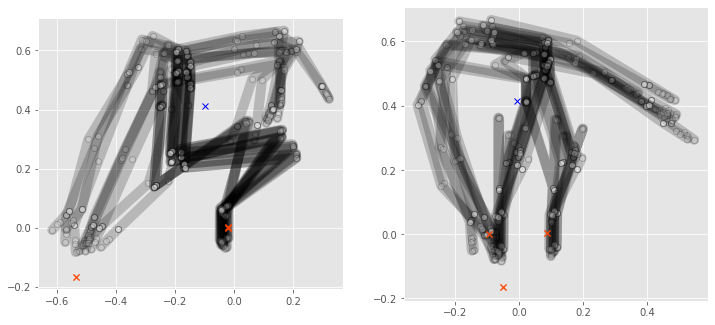

In [27]:
from_dataset = 0
n = 10

_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_targets_v = np.array([0.6] * 3 + [0.001]*3 + [0.001] * 3  )  # variance

if from_dataset:
    _targets = get_target_batch(cut=10000, _batch_size=1) * np.ones((int(n/N_net), 1))
else:
    _targets = np.random.multivariate_normal(_targets_m, np.diag(_targets_v ** 2), (1, )) * np.ones((int(n/N_net), 1))

feed_dict={batch_size: n, batch_target: _targets, eps_var:1.}


_links, _com , _b_targets, _samples_q = sess.run(
    [samples_links, samples_com, batch_target, samples_q], 
    feed_dict)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    
    for j, name in enumerate(chain_names):
        ax[i].plot(_b_targets[:, j*3 + dim[0]], _b_targets[:, j*3 + dim[1]], 'rx', color='orangered')
    ax[i].plot(_com[0, dim[0]], _com[0, dim[1]], 'bx')
    #ax[i].set_xlim([-.7, .7])
    #x[i].set_ylim([-0.1, 1.2])
plt.savefig('data/talos_config.png')
plt.show()  


## Part 2: Use GAN for Projection, IK and Inverse Kinematics

### Setup Pybullet

In [28]:
import pybullet as p
import pybullet_data
from utils import *
from scipy.optimize import fmin_bfgs
from costs import *
from robot import *
from scipy.optimize import fmin_bfgs
from functools import partial

In [29]:
physics_client_id = p.connect(p.GUI)

p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

In [30]:
p.resetSimulation()

#### Load in pybullet

In [31]:
#load robot
robot_urdf = rl.datapath + '/urdf/talos_reduced.urdf';
robot_id = p.loadURDF(fileName=robot_urdf)
dof = p.getNumJoints(robot_id)

#load plane
plane_id = p.loadURDF('plane.urdf')
p.resetBasePositionAndOrientation(plane_id, (0,0,0), np.array([0,0,0,1]))

#set default visualization function
set_q_std = partial(set_q,robot_id, pb_joint_indices, set_base=True)
set_q_std(q0Complete)
vis_traj_std = partial(vis_traj, vis_func = set_q_std)

In [32]:
_,_, ball_id = create_primitives(radius = 0.1)

#### Define frame indices

In [33]:
pb_frame_names = [p.getJointInfo(robot_id,i)[1] for i in range(dof)]

In [34]:
pb_lh_frame_id = pb_frame_names.index(b'gripper_left_joint')
pb_rh_frame_id = pb_frame_names.index(b'gripper_right_joint')
pb_lf_frame_id = pb_frame_names.index(b'leg_left_sole_fix_joint')
pb_rf_frame_id = pb_frame_names.index(b'leg_right_sole_fix_joint')

#### Load from pinocchio

In [35]:
robot_urdf = rl.datapath + '/urdf/talos_reduced.urdf';
rmodel = pin.buildModelFromUrdf(robot_urdf , pin.JointModelFreeFlyer())
rdata = rmodel.createData()

robot_joint_limits = np.vstack([rmodel.lowerPositionLimit, rmodel.upperPositionLimit])
for i in range(robot_joint_limits.shape[0]):
    for j in range(robot_joint_limits.shape[1]):
        if robot_joint_limits[i,j] < -1e10: robot_joint_limits[i,j] = -1e10
        if robot_joint_limits[i,j] > 1e10: robot_joint_limits[i,j] = 1e10
            
pin_frame_names = [f.name for f in rmodel.frames]
lh_frame_id = rmodel.getFrameId('gripper_left_joint')
rh_frame_id = rmodel.getFrameId('gripper_right_joint')
lf_frame_id = rmodel.getFrameId('leg_left_sole_fix_joint')
rf_frame_id = rmodel.getFrameId('leg_right_sole_fix_joint')

#### Define target poses

In [36]:
#left foot
pos_lf, ori_lf = computePose(rmodel,rdata,lf_frame_id,q0Complete)
rpy_lf = mat2euler(ori_lf)
pose_lf_ref = np.concatenate([pos_lf, rpy_lf])
#right foot
pos_rf, ori_rf = computePose(rmodel,rdata,rf_frame_id,q0Complete)
rpy_rf = mat2euler(ori_rf)
pose_rf_ref = np.concatenate([pos_rf, rpy_rf])
#left hand
pos_lh, ori_lh = computePose(rmodel,rdata,lh_frame_id,q0Complete)
pose_lh_ref = np.concatenate([np.array([0.3,0.2, 0.4]), np.array([0,-np.pi/2,0.])])
#right hand
pos_rh, ori_rh = computePose(rmodel,rdata,rh_frame_id,q0Complete)
rpy_rh = mat2euler(ori_rh)
pose_rh_ref = np.concatenate([pos_rh, rpy_rh])

### Define Projector & IK solver

In [280]:
lf_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_lf_ref,lf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
rf_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_rf_ref,rf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
bound_cost = CostBound(robot_joint_limits)
posture_cost = CostPosture(rmodel, rdata, q0Complete)
com_bounds = np.array([[-0.1,-0.1,0.6],[0.1, 0.1, 1.1]])
cost_com_bounds = CostCOMBounds(rmodel, rdata, com_bounds)
cost_sum = CostSum()

cost_sum.addCost(lf_cost, 20., 'lf_pose', 1e-5)
cost_sum.addCost(rf_cost, 20.,'rf_pose', 1e-5)
cost_sum.addCost(bound_cost, 10., 'com_limit', 1e-4)
cost_sum.addCost(cost_com_bounds, 10., 'joint_limit', 1e-4)
cost_sum.addCost(posture_cost, .01, 'posture', 1e3)

robot_projector = TalosCostProjector(cost_sum)


rh_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_rh_ref,rh_frame_id, sel_vector=np.array([1,1,1,0,0,0]))

cost_sum2 = CostSum()
cost_sum2.addCost(rh_cost, 20., 'rh_pose', 1e-3)
cost_sum2.addCost(lf_cost, 20., 'lf_pose', 1e-5)
cost_sum2.addCost(rf_cost, 20.,'rf_pose', 1e-5)
cost_sum2.addCost(bound_cost, 10., 'com_limit', 1e-4)
cost_sum2.addCost(cost_com_bounds, 10., 'joint_limit', 1e-4)
cost_sum2.addCost(posture_cost, .01, 'posture', 1e3)

robot_ik_solver = TalosCostProjector(cost_sum2)

#### Using GAN sampler

In [281]:
class GANSampler():
    def __init__(self, target_sampler):
        self.target_sampler = target_sampler
    
    def sample(self,N = 1, _poses = None, var = 1., idx_input = None):
        if _poses is None:
            _poses = self.target_sampler.sample(N)
        self.poses = _poses
        _foot_poses = np.tile(np.concatenate([pose_rf_ref[:3], pose_lf_ref[:3]]), (N,1))
        _targets = np.hstack([_poses, _foot_poses])
        feed_dict={batch_size: N*N_net, batch_target: _targets, eps_var:var}
        feed_dict[batch_foot_ori] = _batch_foot_ori

        _samples_q = sess.run([samples_q],feed_dict)
        _samples_q = _samples_q[0]
        qnew = []
        for i in range(N):
            #samples from N_net networks
            if idx_input is None:
                idx = np.random.randint(N_net)
            else:
                idx = idx_input
            q = _samples_q[idx*N + i]
            qnew += [get_pb_config(q)]
        return np.array(qnew)

In [282]:
#define standard sampler
base_sampler = sampler(com_bounds.copy())
joint_sampler = sampler(robot_joint_limits[:,7:])
rob_sampler = talos_sampler(base_sampler, np.array([0,0,0,1]), joint_sampler)

#define GAN sampler
target_bounds = np.array([[-0.6, -.6, 0.3], [0.8, .6, 1.4]])
#target_bounds = np.array([[0.2, -.6, 0.3], [0.8, .6, 1.4]])
target_sampler = sampler( target_bounds)
gan_sampler = GANSampler(target_sampler)

#### Try GAN sampler


In [283]:
#q = gan_sampler.sample(_poses = np.array([[-0.2, -0.3, 1.]]))[0]
q = gan_sampler.sample()[0]
set_q_std(q)

#### Compare the projector

In [284]:
methods = [rob_sampler, gan_sampler]
method_names = ['Random', 'GAN']

samples = gan_sampler.sample(1000)

N = 100

data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    for i in range(N):
        #idx = np.random.randint(500)
        idx = i
        if method_names[m] == 'GAN':
            q = samples[idx]
        else:
            q = rob_sampler.sample().flatten()
        tic = time.time()
        res = robot_projector.project(q)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
    data[method_names[m]] = [comp_times, success, fevals]

In [285]:
for m in range(len(methods[:2])):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

& Random & 86.0 &  50.7 $\pm$ 69.3 &  23.2 $\pm$ 12.4 &  36.3 $\pm$ 19.7\\ 
& GAN & 100.0 &  5.4 $\pm$ 3.0 &  5.4 $\pm$ 3.0 &  8.5 $\pm$ 4.7\\ 


### Compare the IK solver

In [290]:
targets = data_target[:2000,:3]
samples = gan_sampler.sample(N=2000, _poses=targets, var = 0.1)

In [291]:
N = 100
data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    for i in range(N):
        idx = i
        if method_names[m] == 'GAN':
            q = samples[idx]
        else:
            q = rob_sampler.sample().flatten()
        tic = time.time()
        robot_ik_solver.cost.costs['rh_pose'].cost.desired_pose[:3] = targets[i]
        res = robot_ik_solver.project(q)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
        data[method_names[m]] = [comp_times, success, fevals]
clear_output()

In [292]:
for m in range(len(methods[:2])):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

& Random & 80.0 &  88.1 $\pm$ 90.5 &  43.8 $\pm$ 20.1 &  54.0 $\pm$ 24.8\\ 
& GAN & 100.0 &  10.7 $\pm$ 8.5 &  10.7 $\pm$ 8.5 &  13.4 $\pm$ 10.5\\ 


## Comparing IK using LBFGS vs Pseudo Inverse

#### Define target poses

In [969]:
from costs_pseudo import *

In [968]:
#left foot
w_lf = mat2w(ori_lf)
pose_lf_ref_new = pin.SE3(ori_lf, pos_lf)
#right foot
w_rf = mat2w(ori_rf)
pose_rf_ref_new = pin.SE3(ori_rf, pos_rf)
#right hand
w_rh = mat2w(ori_rh)
pose_rh_ref_new = pos_rh

In [1022]:
# lf_cost_new = CostFrameRPYFloatingBaseNew(rmodel, rdata, pose_lf_ref,lf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
# rf_cost_new = CostFrameRPYFloatingBaseNew(rmodel, rdata, pose_rf_ref,rf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
# rh_cost_new = CostFrameTranslationFloatingBaseNew(rmodel, rdata, pose_rh_ref[:3],rh_frame_id, weight=np.array([1,1,1]))
lf_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_lf_ref_new,lf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rf_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_rf_ref_new,rf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rh_cost_new = CostFrameTranslationFloatingBaseNew(rmodel, rdata, pose_rh_ref_new,rh_frame_id, weight=np.array([1.,1.,1.]))
cost_com_bounds_new = CostCOMBoundsNew(rmodel, rdata, com_bounds, 1e-12)
bound_cost_new = CostBoundNew(robot_joint_limits, 1e-12)
posture_cost_new = CostPostureNew(rmodel, rdata, q0Complete)

In [1049]:
cost_sum_new = CostSumNew(rmodel, rdata)
cost_sum_new2 = CostSumNew(rmodel, rdata)
cost_sum_new_ik = CostSumNew(rmodel, rdata)

In [1050]:
cost_sum_new_ik.addCost(lf_cost_new, 20., 'lf_pose', 1e-4)
cost_sum_new_ik.addCost(rf_cost_new, 20.,'rf_pose', 1e-4)
cost_sum_new_ik.addCost(cost_com_bounds_new, 20., 'com_limit', 1e-3)
cost_sum_new_ik.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)
cost_sum_new_ik.addCost(rh_cost_new, 20.,'rh_pose', 1e-3)

In [1051]:
cost_sum_new.addCost(lf_cost_new, 20., 'lf_pose', 1e-4)
cost_sum_new.addCost(rf_cost_new, 20.,'rf_pose', 1e-4)
cost_sum_new.addCost(cost_com_bounds_new, 20., 'com_limit', 1e-3)
cost_sum_new.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)

In [1052]:
cost_sum_new2.addCost(posture_cost_new, 1. , 'posture', 1e3)

In [1053]:
rob_projector = TalosCostProjectorNew(cost_sum_new, cost2 = cost_sum_new2)

In [1054]:
robot_ik_solver = TalosCostProjectorNew(cost_sum_new_ik, cost2 = cost_sum_new2)

## Evaluate Speed

In [1055]:
%%timeit -n 10 -r 10 
rh_cost_new.res = (rh_cost_new.rdata.oMf[rh_cost_new.ee_frame_id].translation-rh_cost_new.desired_pose) 

3.69 µs ± 1.22 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [1030]:
a = np.random.rand(3)
b = np.random.rand(6)

In [1031]:
w = 1.*rh_cost_new.weight

In [1032]:
%%timeit -n 10 -r 10
a*w

883 ns ± 423 ns per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [1033]:
q = rob_sampler.sample()[0]

#### Cost speed

In [1084]:
%timeit -n 100 -r 100 rh_cost_new.calc(q)

4.6 µs ± 262 ns per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [1085]:
%timeit -n 100 -r 100 lf_cost_new.calc(q)

6.98 µs ± 2.41 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [1086]:
%timeit -n 100 -r 100 rf_cost_new.calc(q)

6.49 µs ± 882 ns per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [1087]:
%timeit -n 100 -r 100 bound_cost_new.calc(q)

8.19 µs ± 1.22 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [1088]:
%timeit -n 100 -r 100 cost_com_bounds_new.calc(q)

15.6 µs ± 4.6 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [1094]:
%timeit -n 100 -r 100 cost_sum_new.calc(q)

90.4 µs ± 2.67 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [1078]:
%timeit -n 100 -r 100 posture_cost_new.calcDiff(q)

209 ns ± 1.9 ns per loop (mean ± std. dev. of 100 runs, 100 loops each)


***

In [1056]:
rob_projector.mu = 1e-5
rob_projector.mu_ext = 1e-6
rob_projector.alpha2 = .2

In [1057]:
target_bounds = np.array([[0.3, -.4, 0.6], [0.8, .4, 1.1]])
#target_bounds = np.array([[0.2, -.6, 0.3], [0.8, .6, 1.4]])
target_sampler = sampler( target_bounds)


In [1058]:
success = 0
fail = 0

In [1061]:
for i in range(1):
    #goal = np.array([0.3, -0.6, 1.2])
    goal = target_sampler.sample()[0]
    #goal = targets[np.random.randint(1000)]
    p.resetBasePositionAndOrientation(ball_id, goal, (1,0,0,0))

    #q = gan_sampler.sample(_poses = goal[None,:])[0]
    q = rob_sampler.sample()[0]
    #q = gan_sampler.sample()[0]
    set_q_std(q)

    rh_cost_new.desired_pose = goal

    res = rob_projector.project(q, maxiter = 100)

    set_q_std(res['q'])
    print(res['stat'], res['nfev'])
    print(cost_sum_new.feasibles)
    print(cost_sum_new2.feasibles)
    if res['stat']:
        success += 1
    else:
        fail += 1
    clear_output()

    print(success, fail)

3 0


In [1062]:
class TalosCostProjectorNew():
    def __init__(self, cost, cost2 = None, alpha=1, alpha2 = 0.1, alpha_fac = 0.5, c1 = 1e-4, mu = 1e-5, mu_ext = 1e-6):
        self.cost = cost
        self.cost2 = cost2
        self.alpha = alpha
        self.alpha2 = alpha
        self.alpha_fac = alpha_fac
        self.c1 = c1
        self.mu = mu
        self.mu_ext  = mu_ext
        
    def project(self, q, maxiter = 50):
        self.cost.reset_iter()
        if self.cost2 is not None:
            self.cost2.costs['posture'].cost.desired_posture = q.copy()

            self.cost2.costs['posture'].cost.desired_posture[-14:-7] = q0Complete[-14:-7]  # for the left hand, use the default posture
        
        for i in range(maxiter):
            q, status = self.step(q)
            if status is True: break
        res = {'stat': status, 'q': self.cost.qs[-1], 'qs': self.cost.qs, 'nfev': i+1,
               'feval': self.cost.feval}
        return res
    
    def find_direction(self, q):
        r1 = self.cost.calc(q)
        J1 = self.cost.calcDiff(q)
        rcond = self.mu*r1.T.dot(r1) + self.mu_ext
        J1_pinv = np.linalg.pinv(J1, rcond=rcond)
        #J1_pinv = np.linalg.inv(J1.T.dot(J1)+rcond*np.eye(J1.shape[1])).dot(J1.T)
        #print(np.allclose(J1_pinv, J1_pinv2))
        dq1 = J1_pinv.dot(r1)
        
        if self.cost2 is None:
            return dq1
        
        N1 = np.eye(J1.shape[1]) - J1_pinv.dot(J1)
        r2 = self.cost2.calc(q)
        rcond2 = self.mu_ext #+  self.mu*r2.T.dot(r2) 
        J2 = self.cost2.calcDiff(q)
        dq2 = np.linalg.lstsq(J2.dot(N1), r2 - J2.dot(dq1), rcond=rcond2)[0]
        #dq2 = np.linalg.pinv(J2.dot(N1), rcond=rcond2).dot(r2 - J2.dot(dq1))
        
        dq = dq1 + self.alpha2*N1.dot(dq2)
        return dq
    
    def step(self, q, max_iter = 100, line_search = True):
        #find step direction
        dq = self.find_direction(q)
        C = self.cost.res.dot(self.cost.J).dot(dq)
        #line search
        c0 = np.sum(self.cost.res**2)
        alpha = self.alpha
        c = 1e10
        i = 0
        if line_search:
            while c >= c0 - self.c1*alpha*C + 1e-5 :
                qn = q - alpha*dq
                qn = clip_bounds(qn, bound_cost_new.bounds)
                r1 = self.cost.calc(qn)
                c = np.sum(self.cost.res**2)
                i += 1
                #print(alpha,c,c0)     
                alpha = alpha*self.alpha_fac
                if i > max_iter:
                    print('Cannot get a good step length')
                    break
            q = qn
        else:
            q = q - alpha*dq
            r1 = self.cost.calc(qn)
        #print(i,c,c0)  
        
        feasible1 = False not in self.cost.feasibles
        if self.cost2 is None:
            return q, feasible1
        else:
            r2 = self.cost2.calc(q)
            feasible2 = False not in self.cost2.feasibles
            return q, (feasible1 and feasible2)

In [1063]:
def clip_bounds(q, bounds):
#     D = q.shape[0]
#     for i in range(D):
#         if q[i] < bounds[0,i]: q[i] = bounds[0,i]
#         if q[i] > bounds[1,i]: q[i] = bounds[1,i]            
    return np.clip(q, bounds[0], bounds[1])

***

#### Compare the projector

In [1064]:
rob_projector.mu = 1e-4
rob_projector.mu_ext = 1e-6
rob_projector.alpha2 = 0.3

In [1067]:
methods = [rob_sampler, gan_sampler]
method_names = ['Random', 'GAN']
# methods = [gan_sampler]
# method_names = ['GAN']

samples = gan_sampler.sample(1000)

N = 100

data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    qs = []
    for i in range(N):
        #idx = np.random.randint(500)
        idx = i
        if method_names[m] == 'GAN':
            q = samples[idx]
        else:
            q = rob_sampler.sample().flatten()
        tic = time.time()
        res = rob_projector.project(q, maxiter = 40)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
        qs += [res['q']]
    data[method_names[m]] = [comp_times, success, fevals, qs]

In [1068]:
for m in range(len(methods[:2])):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals, qs = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

& Random & 90.0 &  20.6 $\pm$ 24.3 &  12.9 $\pm$ 7.1 &  8.5 $\pm$ 4.2\\ 
& GAN & 100.0 &  3.1 $\pm$ 1.3 &  3.1 $\pm$ 1.3 &  2.2 $\pm$ 0.8\\ 


### Compare the IK solver

In [1069]:
robot_ik_solver.mu = 1e-4
robot_ik_solver.mu_ext = 1e-6
robot_ik_solver.alpha2 = 0.3

In [1070]:
targets = data_target[:2000,:3]
targets = target_sampler.sample(2000)
samples = gan_sampler.sample(N=2000, _poses=targets, var = 0.1)

In [1071]:
methods = [rob_sampler, gan_sampler]
method_names = ['Random', 'GAN']
N = 100
data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    for i in range(N):
        idx = i
        if method_names[m] == 'GAN':
            q = samples[idx]
        else:
            q = rob_sampler.sample().flatten()
        tic = time.time()
        robot_ik_solver.cost.costs['rh_pose'].cost.desired_pose[:3] = targets[i]
        res = robot_ik_solver.project(q, maxiter = 40)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
        data[method_names[m]] = [comp_times, success, fevals]
clear_output()

In [1072]:
for m in range(len(methods[:2])):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

& Random & 88.0 &  32.2 $\pm$ 31.8 &  22.1 $\pm$ 15.1 &  12.5 $\pm$ 6.6\\ 
& GAN & 100.0 &  3.1 $\pm$ 0.5 &  3.1 $\pm$ 0.5 &  2.1 $\pm$ 0.3\\ 


In [ ]:
### Compare IK

In [ ]:
1. Nullspace projection: ok
2. Steplength line search: ok
3. Change to se3 operation
4. Remove joint bound from cost
5. Determine:
    - damping parameters
    - line search: how to do it with nullspace
    - optimize the computation time
    - hierarchical priority: choose wisely
    - test on cRRT

In [ ]:
Questions to Joseph:
1. How to do line search with nullspace
2. Line search increases computational time
3. 